In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
np.seterr(divide='ignore', invalid='ignore')
%matplotlib inline

In [2]:
#%run Determinación_de_Temperatura.ipynb

In [3]:
#Propiedades físicas

#White coating
blanco_alfa = 0.2
blanco_epsi = 0.88

#Solar Panel
alfa = 0.9
epsi = 0.83

A = 0.3 * 0.3 #Area Al node

gen = 0.2 #Area efectiva generacion - Eficiencia

K = 130 #aluminio #W/mK 

Ac = 2e-3 * 0.3 #ärea Contacto
l = 0.3

m = 2810 * 0.3 * 0.3 * 1e-3
cp = 960 #J/kg*K

m_central = 10
cp_central = 1000

sigma=5.67e-8 #W/(m^2*K^4) Boltzmann

In [4]:
print(m*cp)

242.78399999999996


In [5]:
#Constantes simulación
periodo = 5982 #segundos
vueltas = 1
lim = vueltas * periodo
paso = 2 #segundos

In [6]:
#INFRARROJO
F_ir = np.array([1, 0.25, 0.25, 0.25, 0.25, 0, 0])
q_ir = 160
Qir = np.zeros((7,360))
carga_ir = np.zeros((7,int(lim/paso)))

#SOLAR
q_s = 2612.94
F_s = np.zeros((7,360))
carga_solar = np.zeros((7,int(lim/paso)))

#ALBEDO
F_a = F_ir
al=0.76
carga_albedo = np.zeros((7,int(lim/paso)))

In [7]:
#Calculo carga IR
for i in range(6):
    if i==1 or i==2:
        Qir[i]=blanco_epsi*F_ir[i]*A*q_ir
    else:
        Qir[i]=epsi*F_ir[i]*A*q_ir

In [8]:
#Calculo factores de vista con el sol
def F_sol (i,nu):
    S=np.array([0,1])
    Fs=np.zeros((7))
    Fs[0]=np.dot(S,((np.array([np.sin(nu),-np.cos(nu)]))/(np.linalg.norm(S)*np.linalg.norm(np.array([np.sin(nu),-np.cos(nu)])))))
    Fs[1]=np.dot(S,np.array([0,0]))/(np.linalg.norm(S)*np.linalg.norm(np.array([0,0])))
    Fs[2]=np.dot(S,np.array([0,0]))/(np.linalg.norm(S)*np.linalg.norm(np.array([0,0])))
    Fs[3]=np.dot(S,np.array([np.sin(nu-np.pi/2),np.cos(nu-np.pi/2)]))/(np.linalg.norm(S)*np.linalg.norm(np.array([np.sin(nu-np.pi/2),np.cos(nu-np.pi/2)])))
    Fs[4]=np.dot(S,np.array([np.sin(nu+np.pi/2),np.cos(nu+np.pi/2)]))/(np.linalg.norm(S)*np.linalg.norm(np.array([np.sin(nu+np.pi/2),np.cos(nu+np.pi/2)])))
    Fs[5]=np.dot(S,np.array([np.sin(nu),np.cos(nu)]))/(np.linalg.norm(S)*np.linalg.norm(np.array([np.sin(nu),np.cos(nu)])))
    return Fs[i]

In [9]:
#Calculo carga solar
def Q_solar(i,nu):
    while (nu >= 2*np.pi):
        nu=nu-2*np.pi
    if F_sol(i,nu) > 0 and (nu <= eclipse1 or nu >= eclipse2) :
        Qs=alfa*F_sol(i,nu)*A*q_s
    else:
        Qs=0
    return Qs

In [10]:
#Calculo carga albedo
eclipse1=114.522431*np.pi/180
eclipse2=245.477569*np.pi/180
Qc=np.zeros((7,7))
def Q_alb (i,nu):
    while (nu >= 2*np.pi):
        nu = nu - 2 * np.pi
    if nu <= np.pi/2 or nu >= 3*np.pi/2 :
        if i==1 or i==2:
            Q = blanco_alfa * F_a[i] * A * q_s * al * np.cos(nu)
        else:
            Q = alfa*F_a[i]*A*q_s*al*np.cos(nu)
    else:
        Q=0
    return Q

In [11]:
#Calculo acople conductivo
def acople_cond(Tj,Ti,j,i):
    if i==j or (i==6 and (j==0 or j==5)) or (j==6 and (i==0 or i==5)):
        Qc=0
    else:
        if (i==6 or j==6):
            Qc=K*Ac*(Tj-Ti)*2/l
        else:
            Qc=K*Ac*(Tj-Ti)/l
    return Qc

In [12]:
#Calculo de generación de potencia de nodo interno
gen_total=0
nu=0
t=0
while t < lim:
    nu += 2 * np.pi * paso * vueltas / lim
    
    gen_total += gen * (Q_solar(0,nu) + Q_solar(3,nu) + Q_solar(4,nu) + Q_solar(5,nu))
    
    gen_total += gen * (Q_alb(0,nu) + Q_alb(3,nu) + Q_alb(4,nu) + Q_alb(5,nu))
    
    t += 1
    
#print("Generacion : ",gen_total*paso/lim,"W por paso")
print("Generacion : ", gen_total / lim,"W por segundo")

#Temperaturas iniciales
T = np.array([383.85063017, 329.58053824, 329.58149267, 339.05478943, 344.62759672, 394.85258174, 335.86776191])


Generacion :  49.11623540224447 W por segundo


In [13]:
T

array([383.85063017, 329.58053824, 329.58149267, 339.05478943,
       344.62759672, 394.85258174, 335.86776191])

In [14]:
#Calculo de temperaturas
Tg = np.zeros((7,int(lim/paso)))

cargas = np.zeros((7,int(lim/paso)))

nu, t = 0, 0

while t < int(lim/paso):
    #Cambio de temperatura debido a cargas externas
    for i in range(7):
        if i == 6:
            T[i] +=  (gen_total / lim) * paso / (m_central * cp_central)
        else:
            if i==1 or i==2:
                T[i] += (paso / (m * cp)) * (blanco_epsi * F_ir[i] * A * q_ir + Q_solar(i,nu) + Q_alb(i,nu) - sigma * blanco_epsi * A * T[i]**4)
            else:
                T[i] += (paso / (m * cp)) * (epsi * F_ir[i] * A * q_ir + Q_solar(i,nu) * (1-gen) + Q_alb(i,nu) * (1-gen) - sigma * epsi * A * T[i]**4)
        
        #Cambio de temperatura debido a acoples térmicos
        for j in range(7):
            if i==6:
                T[i] += (paso/(m_central*cp_central)) * acople_cond(T[j],T[i],j,i)
            else:
                T[i] += (paso/(m*cp)) * acople_cond(T[j],T[i],j,i)
                
        Tg[i,t]=T[i]
        
        #Creacion de vectores para graficar las cargas externas
        if i!=6:
            carga_solar[i,t] = Q_solar(i,nu)
            carga_albedo[i,t] = Q_alb(i,nu)
            if i==1 or i==2:
                carga_ir[i,t] = blanco_epsi * F_ir[i] * A * q_ir
            else:
                carga_ir[i,t] = epsi * F_ir[i] * A * q_ir
            cargas[i,t] = carga_solar[i,t] + carga_albedo[i,t] + carga_ir[i,t]
            
    nu += 2 * np.pi * paso * vueltas / lim
    t += 1

In [15]:
print("Temperaturas finales")
print(T)

Temperaturas finales
[383.84979214 329.57896395 329.57991845 339.05322485 344.62606977
 394.85177077 335.86363206]


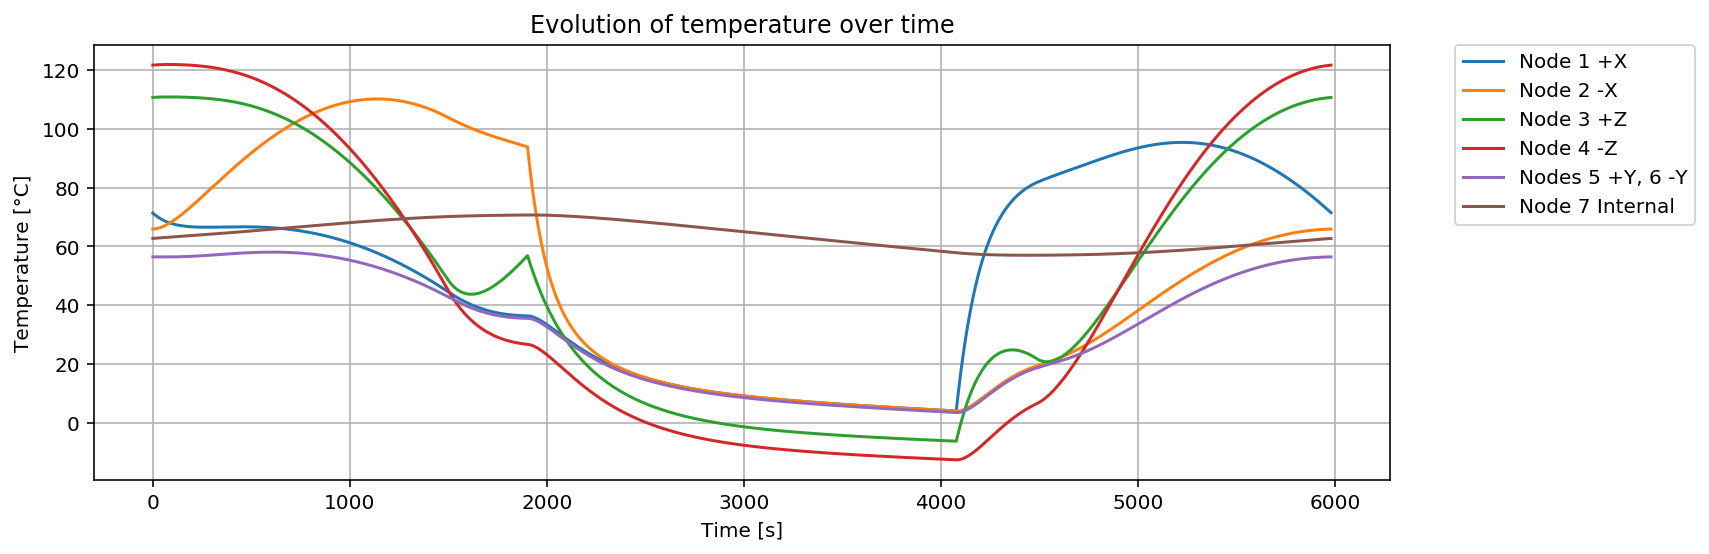

In [16]:
description=np.array([' +Z',' +Y',' -Y',' -X',' +X',' -Z',' Internal'])
number=np.array([3,5,6,2,1,4,7])
order=np.array([4,3,0,5,1,2,6])
fig,ax= plt.subplots()
t= np.arange(0,lim,paso)

for i in range(7):
    if i!=5:
        if i==4:
            ax.plot(t,(Tg[order[i]]-273.15), label='Nodes 5 +Y, 6 -Y')
        else:
            ax.plot(t,(Tg[order[i]]-273.15), label='Node '+str(number[order[i]])+description[order[i]])
            
    ax.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0.)
    plt.subplots_adjust(left=.1, right=1.6)
    ax.set(xlabel='Time [s]', ylabel='Temperature [°C]',title='Evolution of temperature over time')
ax.grid()
plt.show()

In [17]:
Tg

array([[383.86086793, 383.87069008, 383.88010915, ..., 383.82806821,
        383.83913815, 383.84979214],
       [329.58183734, 329.58294668, 329.58387868, ..., 329.57579497,
        329.57747443, 329.57896395],
       [329.5827733 , 329.58386417, 329.58477774, ..., 329.57678644,
        329.57844741, 329.57991845],
       ...,
       [344.50493575, 344.3848971 , 344.26742798, ..., 344.87057899,
        344.74845992, 344.62606977],
       [394.86492355, 394.87680601, 394.88824127, ..., 394.82567032,
        394.8389566 , 394.85177077],
       [335.87750401, 335.88723038, 335.89694153, ..., 335.84409704,
        335.85387264, 335.86363206]])

Temperatures during orbit
Evolution of temperature over time


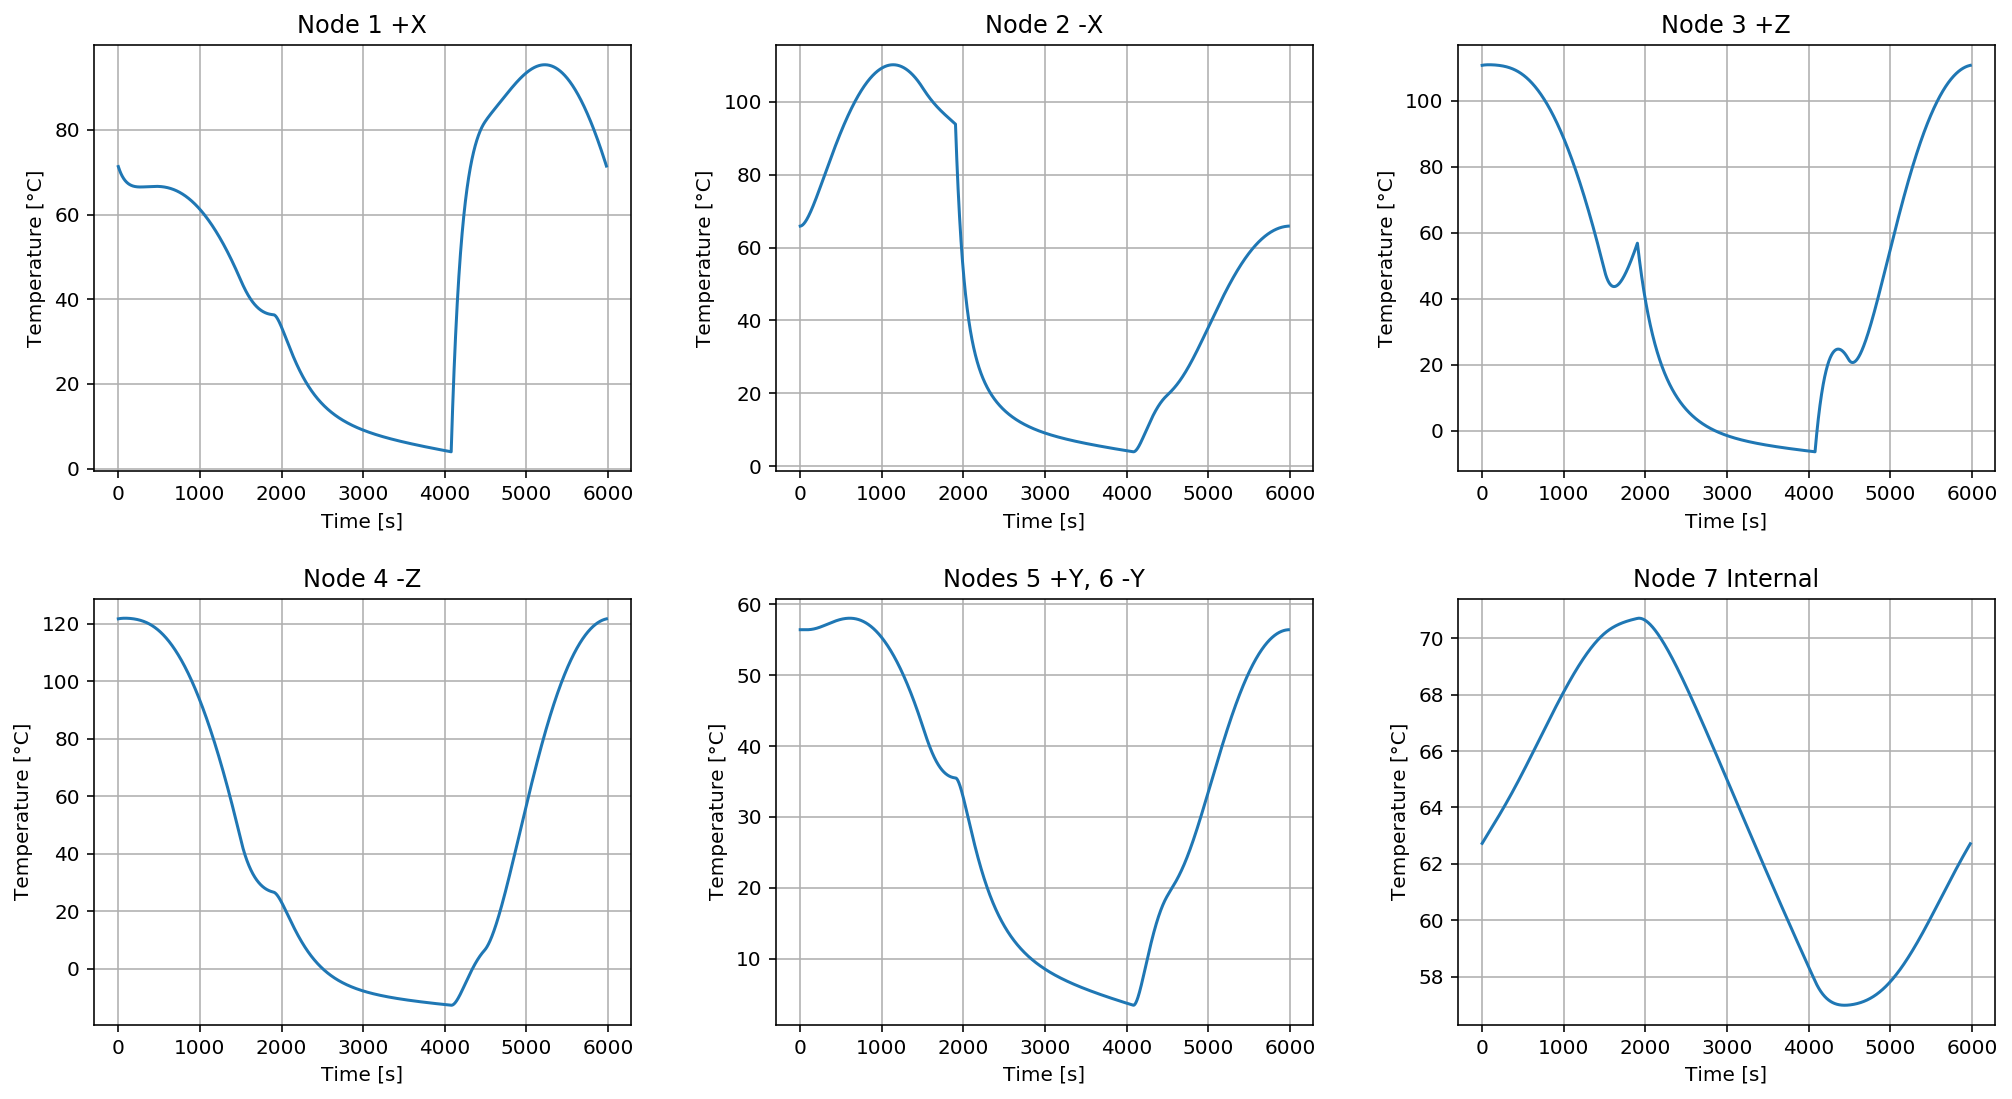

In [18]:
#Temperaturas individuales
print("Temperatures during orbit")
print("Evolution of temperature over time")
fig,ax= plt.subplots()
t= np.arange(0,lim,paso)

for i in range(7):
    if i!=5:
        if i==4:
            plt.subplot(2,3,5)
            plt.plot(t, (Tg[order[i]]-273.15))
            plt.ylabel('Temperature [°C]')
            plt.xlabel('Time [s]')
            plt.title('Nodes 5 +Y, 6 -Y')
        else:
            if i<4:
                plt.subplot(2,3,i+1)
            else:
                plt.subplot(2,3,i)
            plt.plot(t, (Tg[order[i]]-273.15))
            plt.ylabel('Temperature [°C]')
            plt.xlabel('Time [s]')
            plt.title('Node '+str(number[order[i]])+description[order[i]])
        plt.grid(True)

plt.subplots_adjust(top=1.8, bottom=0.1, left=.1, right=2.3,hspace=0.3, wspace=0.27)
plt.show()



In [19]:
#Calculo de Temperaturas maximas y minimas
frio=T
caliente=T
b=0
x=0
for t in range(int(lim/paso)):
    for i in range(7):
        if Tg[i,t]>=caliente[i]:
            caliente[i]=Tg[i,t]
            b=t
        if Tg[i,t]<=frio[i]:
            frio[i]=Tg[i,t]
            x=t

for i in range(7):
    print('Temp max nodo '+str(number[order[i]])+': '+str(np.max(Tg[order[i],:])-273.15)+'°C')
    print('Temp min nodo '+str(number[order[i]])+': '+str(np.min(Tg[order[i],:])-273.15)+'°C')


Temp max nodo 1: 95.40985995783188°C
Temp min nodo 1: 3.9695603111004516°C
Temp max nodo 2: 110.19429710541317°C
Temp min nodo 2: 3.9622846672074843°C
Temp max nodo 3: 110.88141855066141°C
Temp min nodo 3: -6.312388234777302°C
Temp max nodo 4: 121.93015031205164°C
Temp min nodo 4: -12.653878990940314°C
Temp max nodo 5: 58.05389780229524°C
Temp min nodo 5: 3.426647888623336°C
Temp max nodo 6: 58.05427565935656°C
Temp min nodo 6: 3.425891257577007°C
Temp max nodo 7: 70.70779000045565°C
Temp min nodo 7: 56.989246428469755°C


Carga IR
Evolution of IR thermal load absorbed during orbit


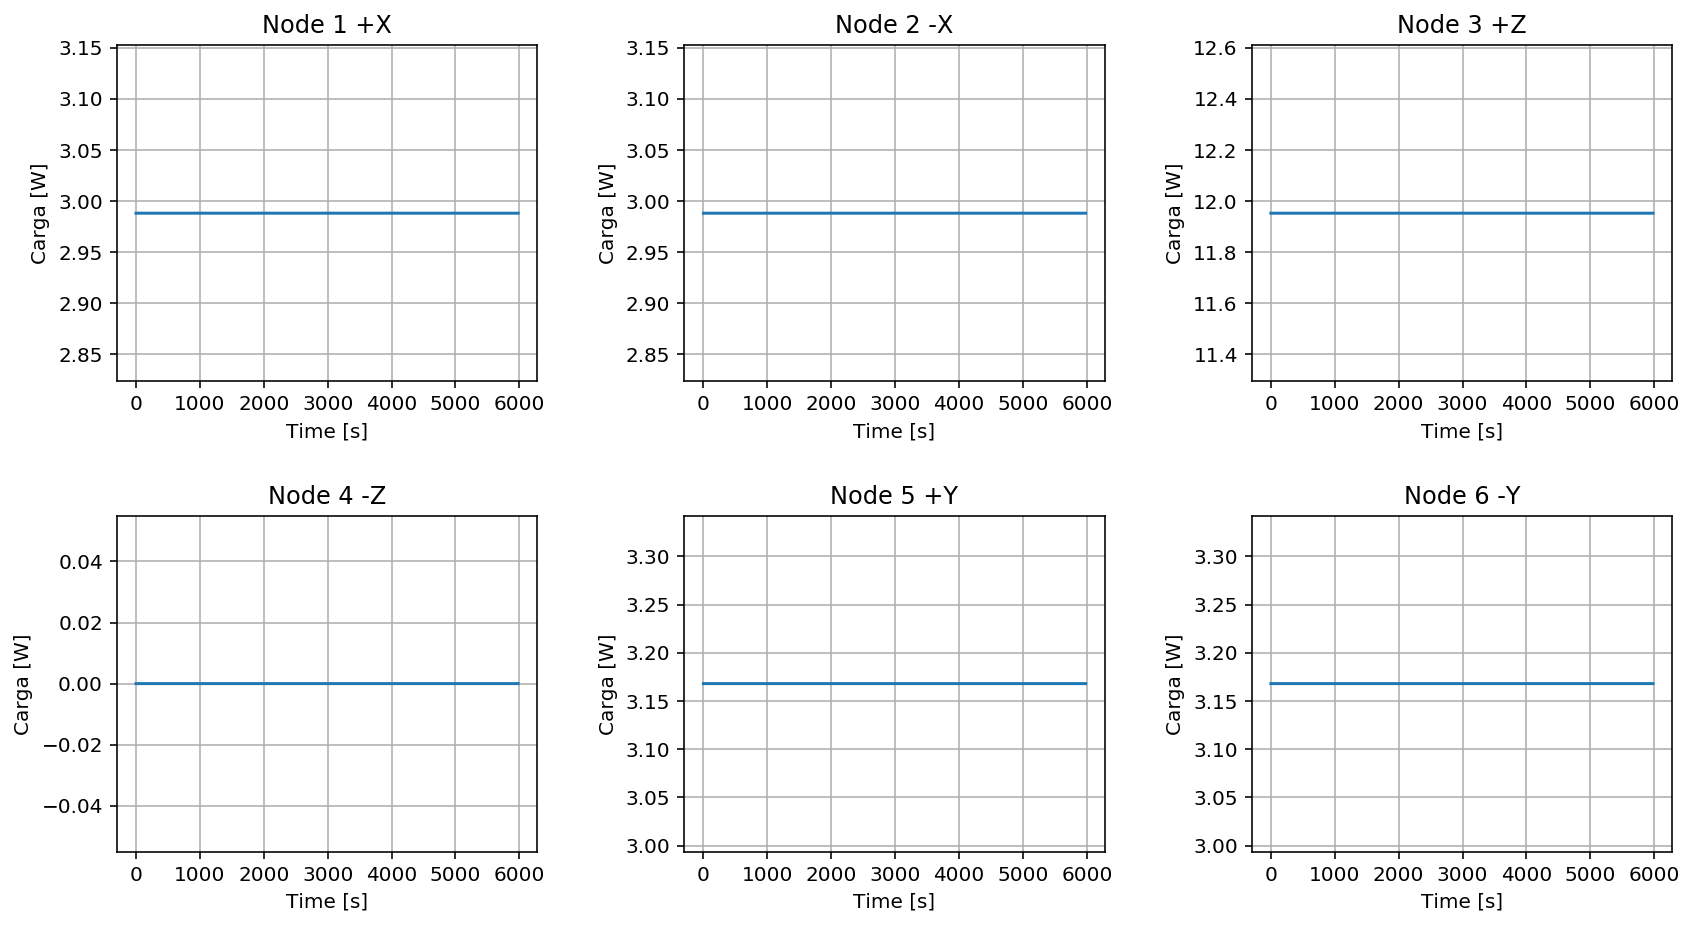

Carga solar
Evolution of solar thermal load absorbed during orbit


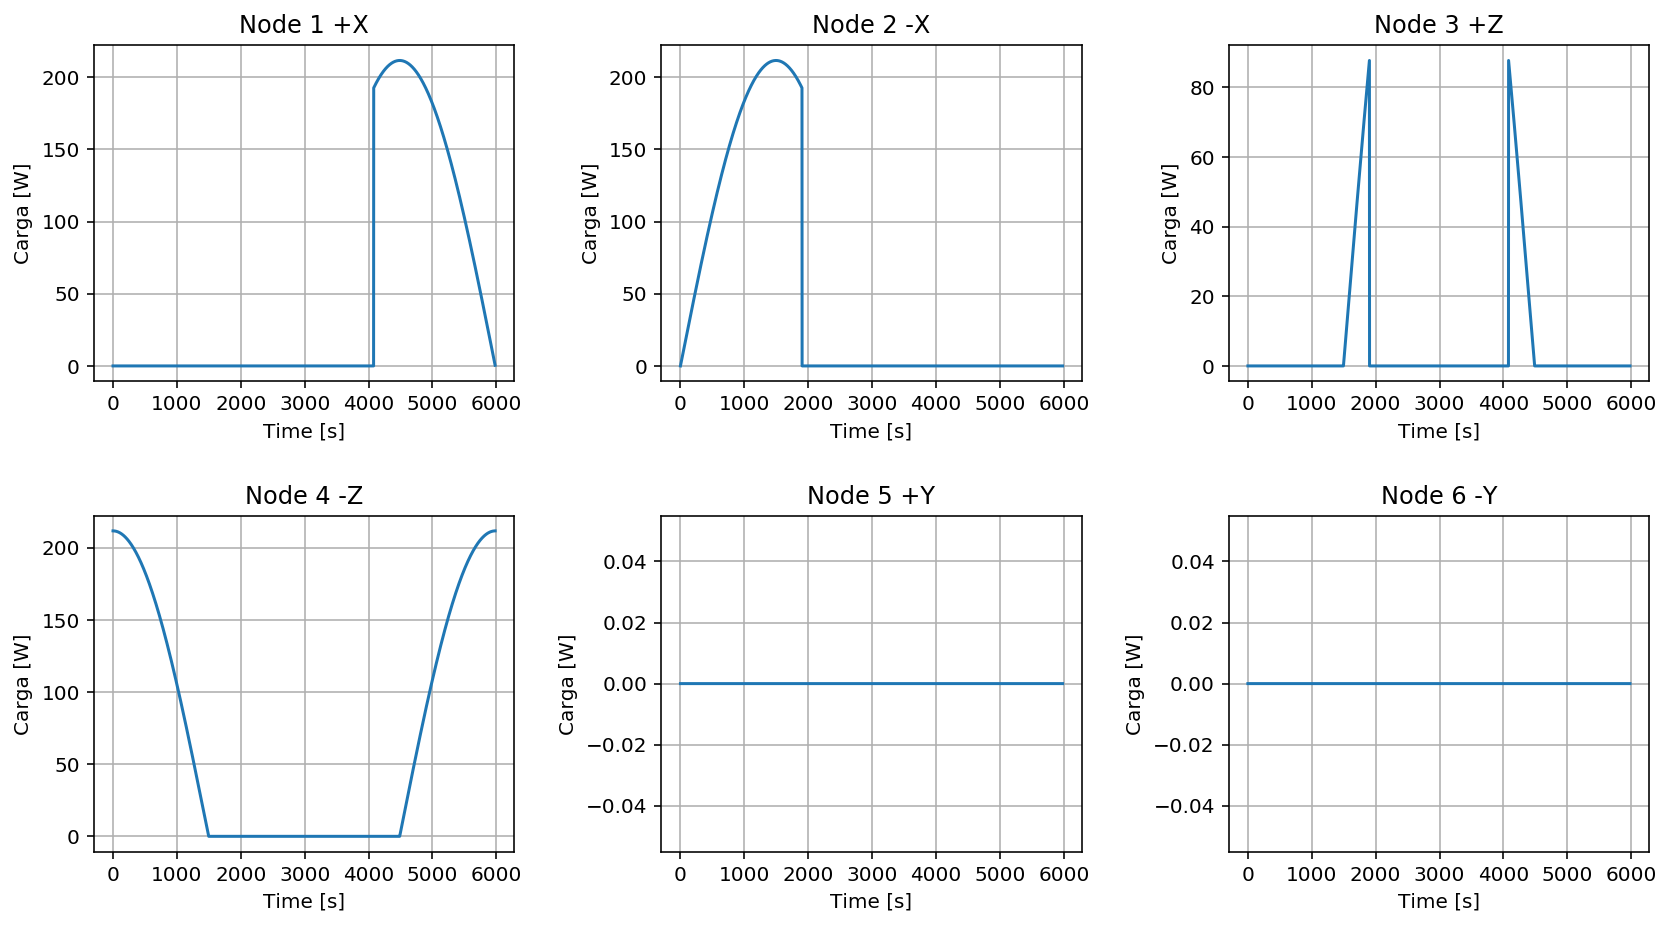

Carga albedo
Evolution of albedo thermal load absorbed during orbit


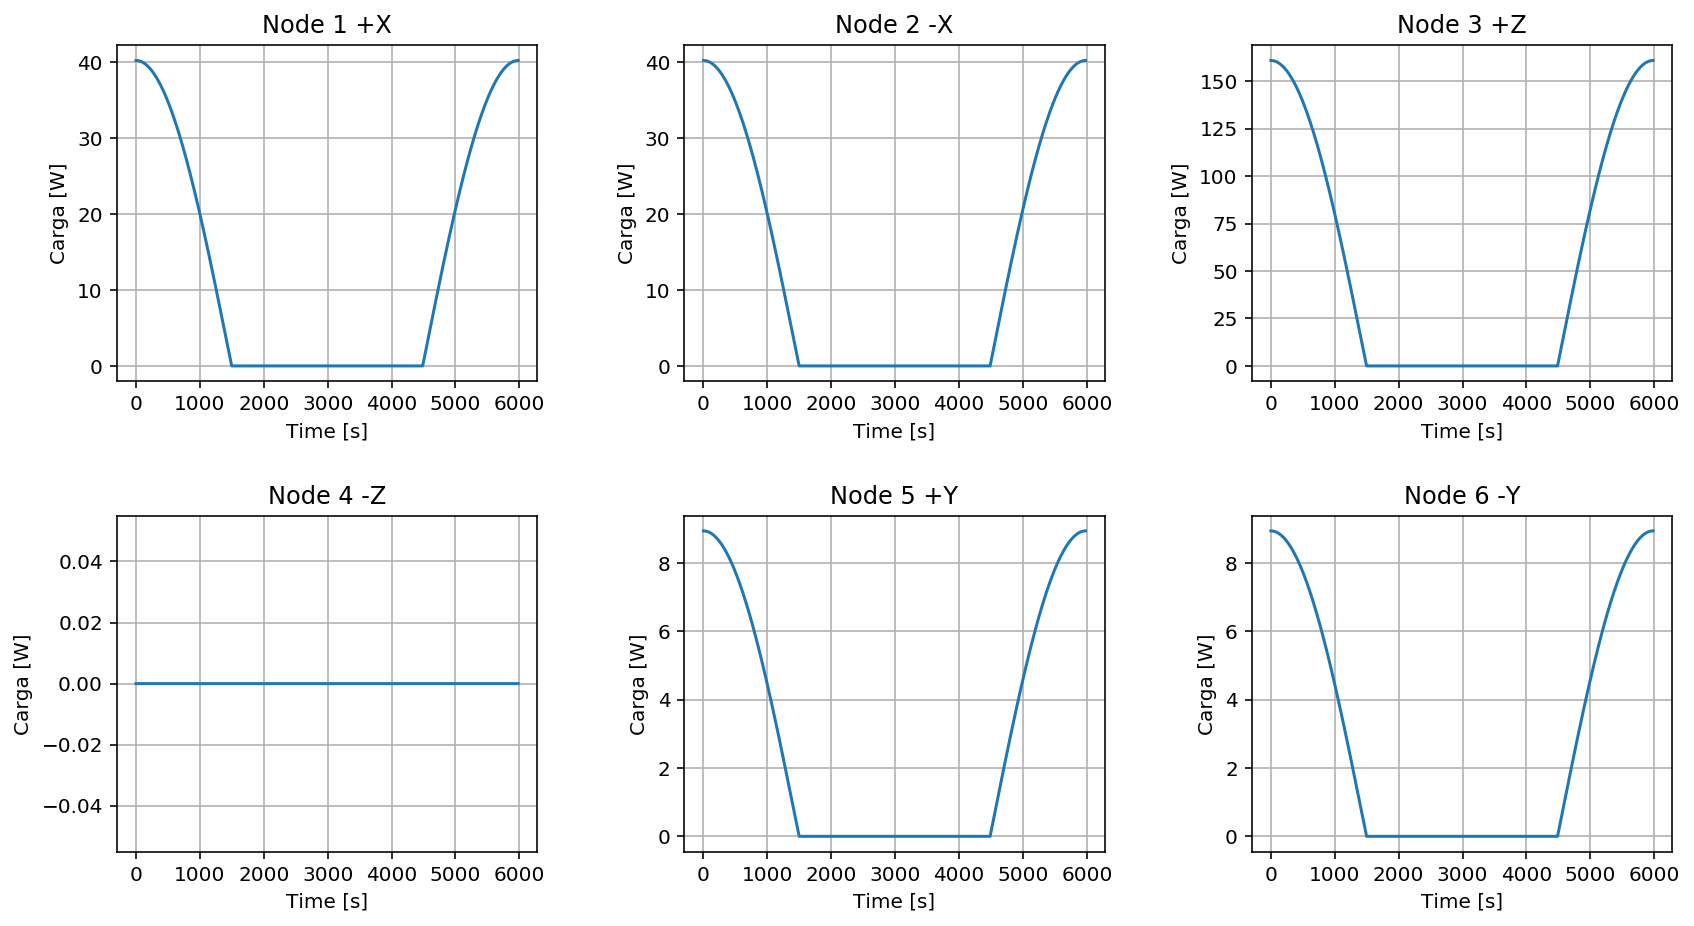

Carga total
Evolution of total thermal load absorbed during orbit


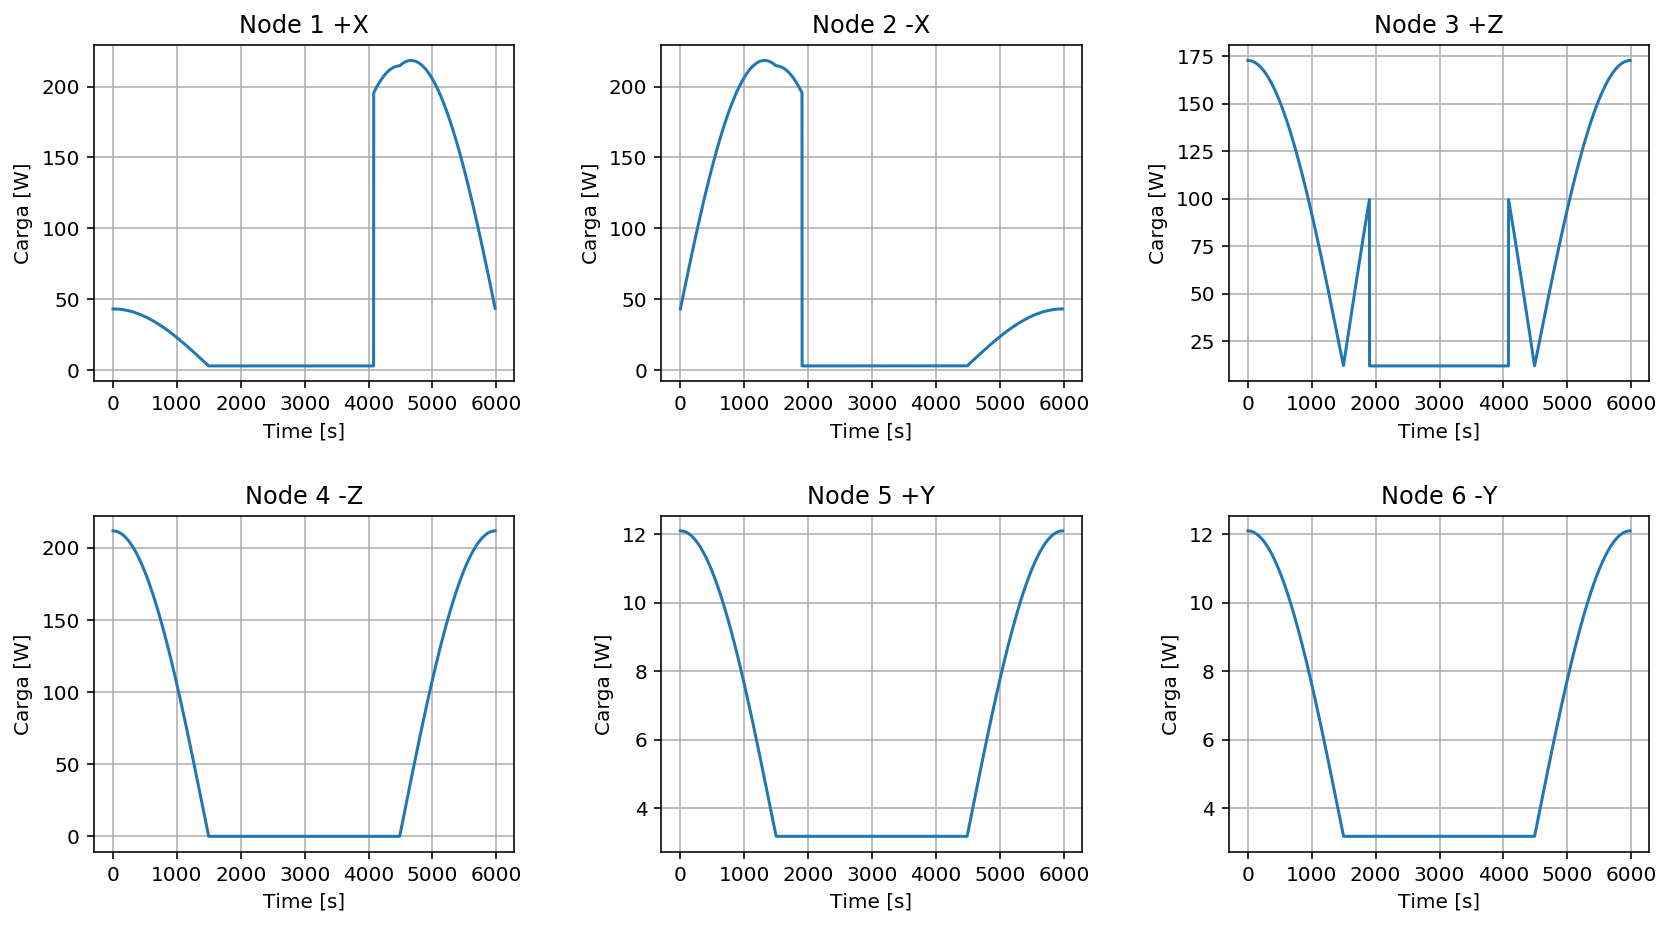

In [20]:
#CARGA INFRARROJO
print("Carga IR")
print("Evolution of IR thermal load absorbed during orbit")
fig,ax= plt.subplots()
t= np.arange(0,lim,paso)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(t, carga_ir[order[i]])
    plt.ylabel('Carga [W]')
    plt.xlabel('Time [s]')
    plt.title('Node '+str(number[order[i]])+description[order[i]])
    plt.grid(True)
    plt.subplots_adjust(top=1.5, bottom=0.1, left=.1, right=1.9,hspace=0.4, wspace=0.35)
plt.show()

#CARGA SOLAR
print("Carga solar")
print("Evolution of solar thermal load absorbed during orbit")
fig,ax= plt.subplots()
t= np.arange(0,lim,paso)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(t, carga_solar[order[i]])
    plt.ylabel('Carga [W]')
    plt.xlabel('Time [s]')
    plt.title('Node '+str(number[order[i]])+description[order[i]])
    plt.grid(True)
    plt.subplots_adjust(top=1.5, bottom=0.1, left=.1, right=1.9,hspace=0.4, wspace=0.35)
plt.show()

#CARGA ALBEDO
print("Carga albedo")
print("Evolution of albedo thermal load absorbed during orbit")
fig,ax= plt.subplots()
t= np.arange(0,lim,paso)
t= np.arange(0,lim,paso)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(t, carga_albedo[order[i]])
    plt.ylabel('Carga [W]')
    plt.xlabel('Time [s]')
    plt.title('Node '+str(number[order[i]])+description[order[i]])
    plt.grid(True)
    plt.subplots_adjust(top=1.5, bottom=0.1, left=.1, right=1.9,hspace=0.4, wspace=0.35)
plt.show()

#CARGAS TOTALES
print("Carga total")
print("Evolution of total thermal load absorbed during orbit")
fig,ax= plt.subplots()
t= np.arange(0,lim,paso)
t= np.arange(0,lim,paso)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(t, cargas[order[i]])
    plt.ylabel('Carga [W]')
    plt.xlabel('Time [s]')
    plt.title('Node '+str(number[order[i]])+description[order[i]])
    plt.grid(True)
    plt.subplots_adjust(top=1.5, bottom=0.1, left=.1, right=1.9,hspace=0.4, wspace=0.35)
plt.show()

In [21]:
plt.plot(nu, T_list[1:,:]);
plt.plot(nu, Tg.T[1:]-273);

NameError: name 'T_list' is not defined

In [22]:
import csv

with open('termicopaper_luis_corregido.csv', mode='w') as temps_file:
    temps_write = csv.writer(temps_file, delimiter=',', quoting=csv.QUOTE_ALL)
    
    temps_write.writerow(['Time', ' +X',' -X',' +Z',' -Z',' +Y',' -Y',' Internal'])
    for i in range(2991):
        temps_write.writerow([i,"%.2f" % Tg[2,i],"%.2f" % Tg[4,i],"%.2f" % Tg[5,i],"%.2f" % Tg[1,i],"%.2f" % Tg[0,i],"%.2f" % Tg[3,i],"%.2f" % Tg[6,i]])

In [27]:
import csv
filtrar = np.array([0, 83, 166, 249, 332, 415, 498, 581, 665, 748, 831, 914, 951, 997, 1080, 1163, 1246, 1329, 1412, 1495, 1578, 1661, 1744, 1827, 1911, 1994, 2039, 2077, 2160, 2243, 2326, 2409, 2492, 2575, 2658, 2741, 2824, 2907, 2991])

flag=0

with open('albedo_luis.csv', mode='w') as al_file:
    al_write = csv.writer(al_file, delimiter=',', quotechar=' ')
    
    al_write.writerow(['Index', ' +X',' -X',' +Z',' -Z',' +Y',' -Y',' Internal'])
    for t in range(2991):
        if filtrar[flag] == t:
            al_write.writerow([flag,"%.2f" % carga_albedo[order[0],t],"%.2f" % carga_albedo[order[1],t],"%.2f" % carga_albedo[order[2],t],"%.2f" % carga_albedo[order[3],t],"%.2f" % carga_albedo[order[4],t],"%.2f" % carga_albedo[order[5],t],"%.2f" % carga_albedo[order[6],t]])
            flag += 1


In [28]:
flag=0

with open('solar_luis.csv', mode='w') as sol_file:
    sol_write = csv.writer(sol_file, delimiter=',', quotechar=' ')
    
    sol_write.writerow(['Index', ' +X',' -X',' +Z',' -Z',' +Y',' -Y',' Internal'])
    for t in range(2991):
        if filtrar[flag] == t:
            sol_write.writerow([flag,"%.2f" % carga_solar[order[0],t],"%.2f" % carga_solar[order[1],t],"%.2f" % carga_solar[order[2],t],"%.2f" % carga_solar[order[3],t],"%.2f" % carga_solar[order[4],t],"%.2f" % carga_solar[order[5],t],"%.2f" % carga_ir[order[6],t]])
            flag += 1

In [29]:

flag=0

with open('ir_luis.csv', mode='w') as ir_file:
    ir_write = csv.writer(ir_file, delimiter=',', quotechar=' ')
    
    ir_write.writerow(['Index', ' +X',' -X',' +Z',' -Z',' +Y',' -Y',' Internal'])
    for t in range(2991):
        if filtrar[flag] == t:
            ir_write.writerow([flag,"%.2f" % carga_ir[order[0],t],"%.2f" % carga_ir[order[1],t],"%.2f" % carga_ir[order[2],t],"%.2f" % carga_ir[order[3],t],"%.2f" % carga_ir[order[4],t],"%.2f" % carga_ir[order[5],t],"%.2f" % carga_ir[order[6],t]])
            flag += 1